In [1]:
# Source : https://towardsdatascience.com/patchtst-a-breakthrough-in-time-series-forecasting-e02d48869ccc
# DOCUMENTATION : https://nixtla.github.io/neuralforecast/examples/installation.html
# ACADEMIC : https://arxiv.org/pdf/2211.14730.pdf

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST, LSTM, TFT
from neuralforecast.auto import AutoNHITS

from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse

from datasetsforecast.long_horizon import LongHorizon

from sklearn.preprocessing import RobustScaler
from neuralforecast.losses.pytorch import MQLoss

from ray import tune

In [2]:
# 206, 25,  plutot bien
# 95, 875 bof

df = pd.read_csv('../prepared_data/01_06_2021_to_20_06_2023_prepared_df_875.csv', parse_dates=['date'])
df = df.rename(columns={'date': 'ds', 'nb_cars':'y'})

In [3]:
#df = df.drop(['nb_cars_cxl', 'nb_bookings', 'nb_cars'], axis=1)

In [4]:
df['unique_id'] = 1

In [5]:
df.head()

,ds,y,nb_cars_cxl,nb_bookings,nb_bookings_cxl,hourly rate,WE package,1 week package,1 month package,other package,...,0H à 6H,18H à 24H,+24h,06:00 24:00,00:30 06:00,00:00 00:30,strike,holidays,vacation,unique_id
0,2021-06-01,9,1,4,0,2,0,6,1,0,...,0,1,9,0,0,0,0,0,0,1
1,2021-06-02,13,0,2,1,4,0,8,1,0,...,0,1,13,0,0,0,0,0,0,1
2,2021-06-03,10,1,6,1,1,0,8,1,0,...,0,0,10,0,0,0,0,0,0,1
3,2021-06-04,14,2,20,1,6,0,7,1,0,...,0,0,14,0,0,0,0,0,0,1
4,2021-06-05,31,3,5,1,6,15,9,1,0,...,0,3,31,0,0,0,0,0,0,1


In [6]:
robust_scaler = RobustScaler()
df['y'] = robust_scaler.fit_transform(df['y'].values.reshape(-1, 1))

In [7]:
val_size_pk = 75
test_size_pk = 150
n_time_pk = 750

print(val_size_pk, test_size_pk)

75 150


0     2021-06-01
1     2021-06-02
2     2021-06-03
3     2021-06-04
4     2021-06-05
         ...    
745   2023-06-16
746   2023-06-17
747   2023-06-18
748   2023-06-19
749   2023-06-20
Name: ds, Length: 750, dtype: datetime64[ns]


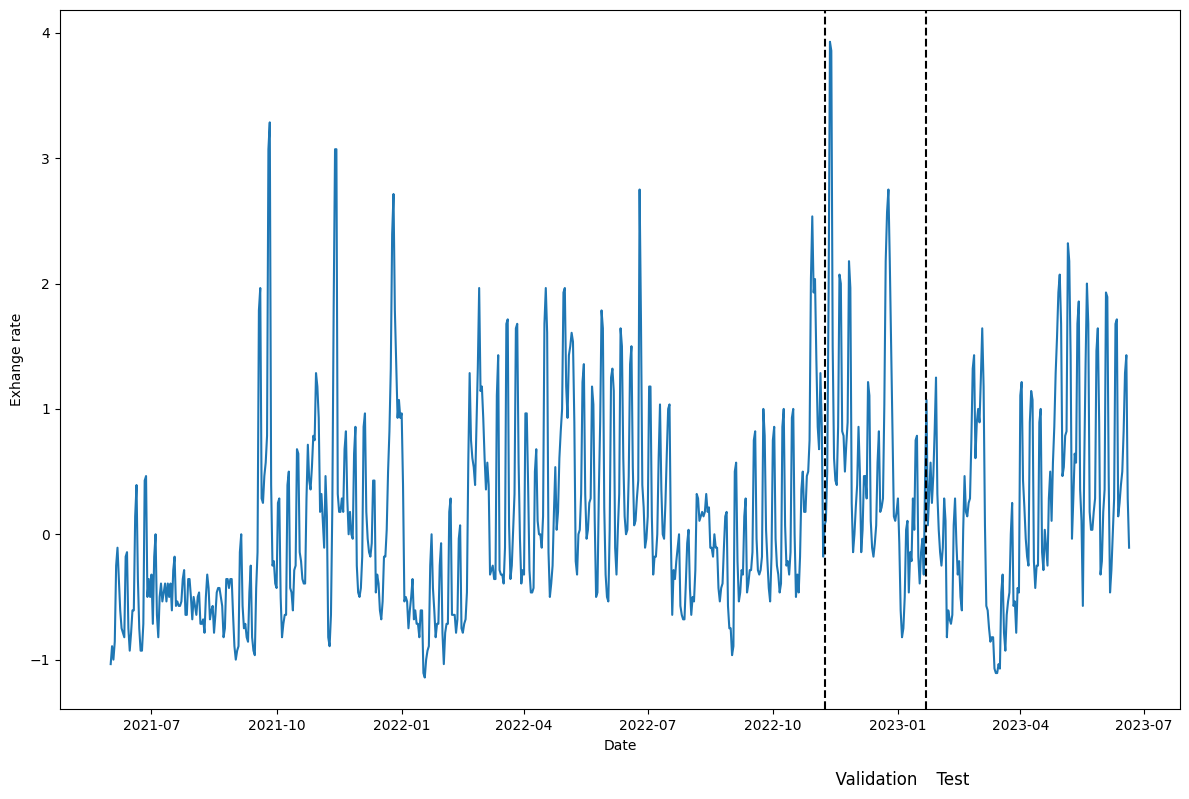

In [8]:
u_id = '1'

x_plot = df['ds']
y_plot = df['y']

print(x_plot)


x_val = x_plot[n_time_pk - val_size_pk - test_size_pk]
x_test = x_plot[n_time_pk - test_size_pk]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_plot, y_plot)
ax.set_xlabel('Date')
ax.set_ylabel('Exhange rate')
ax.axvline(x_val, color='black', linestyle='--')
ax.axvline(x_test, color='black', linestyle='--')

plt.text(x_val, -2, '  Validation', fontsize=12)
plt.text(x_test,-2, '  Test', fontsize=12)

plt.tight_layout()

In [9]:
horizon = 15
max_steps = 1000

models = [
        NHITS(h=horizon,
               input_size=2*horizon,
               hist_exog_list = ['holidays', 'strike'],
               max_steps=max_steps),
        NBEATS(h=horizon,
               input_size=2*horizon,
               hist_exog_list = ['strike', 'holidays'],
               max_steps=max_steps),
        # LSTM(h=horizon,                               # Forecast horizon
        #        max_steps=max_steps,                   # Number of steps to train
        #        encoder_hidden_size=64,                # Defines the size of the hidden state of the LSTM
        #        decoder_hidden_size=64,
        #        hist_exog_list = ['holidays', 'strike'],
        #        ),
        # TFT(h=horizon,
        #          input_size=2*horizon,
        #          max_steps=max_steps),
        PatchTST(h=horizon,
                 input_size=2*horizon,
                 max_steps=max_steps,
                 )
            ]

Global seed set to 1
Global seed set to 1
Global seed set to 1


In [10]:
nf = NeuralForecast(models=models, freq='D')

In [11]:
preds_df = nf.cross_validation(df=df, val_size=val_size_pk, test_size=test_size_pk, n_windows=None, step_size=1)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.98it/s]


In [12]:
y_true = preds_df['y'].values
y_pred_nhits = preds_df['NHITS'].values
y_pred_nbeats = preds_df['NBEATS'].values
# y_pred_lstm = preds_df['LSTM'].values
y_pred_patchtst = preds_df['PatchTST'].values
# y_pred_tft = preds_df['TFT'].values

n_series = len(df['unique_id'].unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_pred_nhits = y_pred_nhits.reshape(n_series, -1, horizon)
y_pred_nbeats = y_pred_nbeats.reshape(n_series, -1, horizon)
# y_pred_lstm = y_pred_lstm.reshape(n_series, -1, horizon)
y_pred_patchtst = y_pred_patchtst.reshape(n_series, -1, horizon)
# y_pred_tft = y_pred_tft.reshape(n_series, -1, horizon)

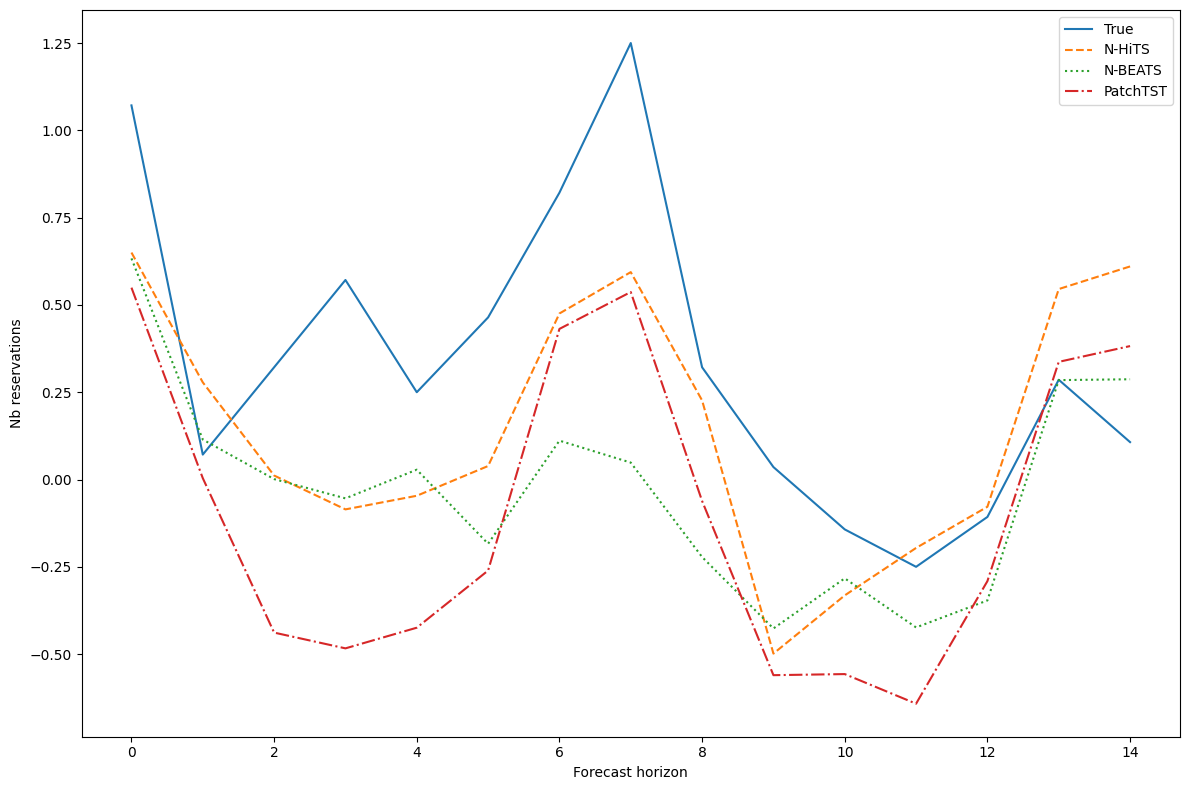

In [13]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(y_true[0, 0, :], label='True')
ax.plot(y_pred_nhits[0, 0, :], label='N-HiTS', ls='--')
ax.plot(y_pred_nbeats[0, 0, :], label='N-BEATS', ls=':')
# ax.plot(y_pred_tft[0, 0, :], label='TFT', ls='-.')
# ax.plot(y_pred_lstm[0, 0, :], label='LSTM', ls=':')
ax.plot(y_pred_patchtst[0, 0, :], label='PatchTST', ls='-.')
ax.set_ylabel('Nb reservations')
ax.set_xlabel('Forecast horizon')
ax.legend(loc='best')

plt.tight_layout()

In [15]:
data = {
        'N-HiTS': [mae(y_pred_nhits, y_true), mse(y_pred_nhits, y_true)],
       'N-BEATS': [mae(y_pred_nbeats, y_true), mse(y_pred_nbeats, y_true)],
    #    'LSTM': [mae(y_pred_lstm, y_true), mse(y_pred_lstm, y_true)],
       'PatchTST': [mae(y_pred_patchtst, y_true), mse(y_pred_patchtst, y_true)]
    #    'TFT': [mae(y_pred_tft, y_true), mse(y_pred_tft, y_true)]
       }

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,PatchTST
mae,0.581497,0.578111,0.568917
mse,0.578724,0.546609,0.510665


In [52]:
nf.save(path='../models/test_run_875_nbeats/',
        model_index=[1], 
        overwrite=True,
        save_dataset=True)

In [16]:
nf2 = NeuralForecast.load(path='../models/test_run_875_nbeats/')
Y_hat_df = nf2.predict().reset_index()
print(Y_hat_df.head())
print(Y_hat_df.shape)

Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 316.43it/s]
   unique_id         ds    NBEATS
0          1 2023-06-21 -0.062886
1          1 2023-06-22  0.061333
2          1 2023-06-23  0.288678
3          1 2023-06-24  0.907175
4          1 2023-06-25  0.824612
(15, 3)


In [56]:
predictions_scaled = Y_hat_df['NBEATS'].values.reshape(-1, 1)

In [55]:
# Inversez la mise à l'échelle
predictions = robust_scaler.inverse_transform(predictions_scaled)

In [39]:
predictions

array([[34.61515868],
       [37.0099619 ],
       [42.73361552],
       [62.91529822],
       [61.17317057],
       [41.437199  ],
       [26.25263917],
       [30.96251583],
       [26.34371769],
       [31.37132984],
       [50.78955257],
       [62.8560195 ],
       [44.11813986],
       [31.57581425],
       [29.67007804]])